In [1]:
import numpy as np
import random
import mne
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import json
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA,FastICA
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from scipy.fftpack import fft,ifft
import math
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from scipy.signal import spectrogram
from mne.preprocessing.ica import ICA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

C:\Anaconda3\lib\site-packages\pandas\__init__.py:7: DeprecationWarning: bad escape \s
  from pandas import hashtable, tslib, lib
C:\Anaconda3\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)
C:\Anaconda3\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)


In [2]:
os.chdir('C:/Users/ning/Downloads/training set')
print(os.listdir(os.getcwd()))
directoryList = os.listdir(os.getcwd())

['64chlocs.elp', 'label_extraction.npy', 'label_extraction.pkl', 's5d2_final.edf', 's5d2_final_annotations.txt', 's6n2_final.edf', 's6n2_final_annotations.txt', 'Sleep Stage Scoring Criteria.docx', 'suj10_d1final.edf', 'suj10_d1final_annotations.txt', 'suj10_d2final.edf', 'suj10_d2final_annotations.txt', 'suj13_l2nap_day2 edited.edf', 'suj13_l2nap_day2 edited1.edf', 'suj13_l2nap_day2 edited1_annotations.txt', 'suj13_l2nap_day2 edited_annotations.txt', 'suj13_l2nap_day2 edited_C3.txt', 'suj13_l2nap_day2 edited_C4.txt', 'suj13_l2nap_day2 edited_F3.txt', 'suj13_l2nap_day2 edited_F4.txt', 'suj13_l2nap_day2 edited_O1.txt', 'suj13_l2nap_day2 edited_O2.txt', 'suj5_d1final.edf', 'suj5_d1final_annotations.txt', 'suj6_d1final.edf', 'suj6_d1final_annotations.txt', 'suj8_d1final.edf', 'suj8_d1final_annotations.txt', 'suj8_d2final.edf', 'suj8_d2final_annotations.txt', 'suj9_d1final.edf', 'suj9_d1final_annotations.txt', 'suj9_d2final.edf', 'suj9_d2final_annotations.txt', 'testing-montage-2.mtg', 'Tr

In [3]:
EDFFind = re.compile("edf", re.IGNORECASE);EDFfiles=[]
TXTFind = re.compile("txt",re.IGNORECASE);TXTfiles=[]
for item in directoryList:
    if EDFFind.search(item):
        EDFfiles.append(item)
    elif TXTFind.search(item):
        TXTfiles.append(item)

In [8]:
def pick_sample_file(EDFfiles,n=0):
    file_to_read=EDFfiles[n]
    fileName = file_to_read.split('.')[0]
    return file_to_read,fileName
def load_data(file_to_read,channelList,low_frequency=5,high_frequency=50):
    """ not just the data, but also remove artifact by using mne.ICA"""
    raw = mne.io.read_raw_edf(file_to_read,stim_channel=None,preload=True)
    raw.pick_channels(channelList)
    if low_frequency != None and high_frequency != None:
        raw.filter(low_frequency,high_frequency)
    elif low_frequency != None or high_frequency != None:
        try: 
            raw.filter(low_frequency,500)
        except:
            raw.filter(0,high_frequency)
    else:
        raw = raw
    ica = ICA(n_components=None, n_pca_components=None, max_pca_components=None,max_iter=1000,
          noise_cov=None, random_state=0)
    picks=mne.pick_types(raw.info,meg=False,eeg=True,eog=False,stim=False)
    ica.fit(raw,picks=picks,decim=3,reject=dict(mag=4e-12, grad=4000e-13))
    ica.detect_artifacts(raw,eog_ch='ROC',eog_criterion=0.5)
    clean_raw = ica.apply(raw,exclude=ica.exclude)
    
    
    return clean_raw

def annotation_to_labels(TXTfiles,sample_number=0,label='markon',last_letter=-1):
    annotation_to_read=[x for x in TXTfiles if fileName in x]
    file = pd.read_csv(annotation_to_read[0])
    #file['Duration'] = file['Duration'].fillna(0)
    labelFind = re.compile(label,re.IGNORECASE)
    windowLabel=[]
    for row in file.iterrows():
        currentEvent = row[1][-1]
        if (labelFind.search(currentEvent)):
          
            windowLabel.append(currentEvent[-1])
    for idx,items in enumerate(windowLabel):
        if items == ' ':
            windowLabel[idx] = windowLabel[idx -1]
    return windowLabel
def relabel_to_binary(windowLabel,label=['2','3']):
    YLabel=[]
    for row in windowLabel:
        if row[0] == label[0] or row[0] == label[1]:
            YLabel.append(1)
        else:
            YLabel.append(0)
    return YLabel
unit_step=lambda x:0 if x<0 else 1
def structure_to_data(channelList,YLabel,raw,sample_points=1000):
    data={}
    for channel_names in channelList:
        data[channel_names]=[]
    data['label']=[]
    channel_index = mne.pick_types(raw.info,meg=False,eeg=True,eog=False,stim=False)
    for sample,labels in zip(range(len(YLabel)),YLabel):
        
        try:
            startPoint=30*sample;endPoint=30*(sample+1)
            start,stop=raw.time_as_index([startPoint,endPoint])
            segment,time=raw[channel_index,start:stop]
            
            for idx, channel_names in enumerate(channelList):
                yf = 20*np.log10(np.abs(np.fft.rfft(segment[idx,:sample_points])))
                data[channel_names].append(yf)
            data['label'].append(labels)
        except:
            print('last window is missing due to error','sample that is passed is',sample)
            #data['label']=scipy.delete(YLabel,sample,0)
            pass
            
    return data
def merge_dicts(dict1,dict2):
    for key, value in dict2.items():
        dict1.setdefault(key,[]).extend(value)
    return dict1

def logistic_func(theta, x):
    return 1./(1+np.exp(x.dot(theta)))
def log_gradient(theta, x, y):
    first_calc = logistic_func(theta, x) - np.squeeze(y)
    final_calc = first_calc.T.dot(x)
    return final_calc
def cost_func(theta, x, y):
    log_func_v = logistic_func(theta,x)
    y = np.squeeze(y)
    step1 = y * np.log(log_func_v)
    step2 = (1-y) * np.log(1 - log_func_v)
    final = -step1 - step2
    return np.mean(final)
def grad_desc(theta_values, X, y, lr=10e-8, converge_change=10e-6):
    #normalize
    #X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    #setup cost iter
    cost_iter = []
    cost = cost_func(theta_values, X, y)
    cost_iter.append([0, cost])
    change_cost = 1
    i = 1
    while(change_cost > converge_change):
        old_cost = cost
        theta_values = theta_values - (lr * log_gradient(theta_values, X, y))
        cost = cost_func(theta_values, X, y)
        cost_iter.append([i, cost])
        change_cost = old_cost - cost
        i+=1;#print(i)
    return theta_values, np.array(cost_iter)
def pred_values(theta, X, hard=True,one_sample=False):
    #normalize
    if not one_sample:
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    pred_prob = logistic_func(theta, X)
    pred_value = np.where(pred_prob >= .5, 1, 0)
    if hard:
        return pred_value
    return pred_prob
def SK_to_data(channelList,markPairs,dataLabels,raw):
    data={}
    for channel_names in channelList:
        data[channel_names]=[]
    data['label']=[]
    channel_index,_=dictionary_for_target_channels(channelList,raw)
    for sample,pairs in enumerate(markPairs):
        #print(idx)
        
        start,stop = raw.time_as_index(pairs)
            
        segment,time=raw[channel_index,start:stop]
        try:    
            for idx,channel_names in enumerate(channelList):
                yf = fft(segment[idx,:]);N=100;#print(channel_names,N)
                data[channel_names].append(np.abs(yf[0:100]))
            data['label'].append(dataLabels[sample])
        except:
            continue
       
    return data
def annotation_file(TXTFiles,sample_number=0):
    annotation_to_read=[x for x in TXTfiles if fileName in x]
    file = pd.read_csv(annotation_to_read[0])
    #file['Duration'] = file['Duration'].fillna(0)
    return file

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def center_window_by_max_amplitude(raw,time,channelList,windowsWidth=2.0):
    startPoint=time-windowsWidth;endPoint=time+windowsWidth
    start,stop=raw.time_as_index([startPoint,endPoint])
    tempsegment,timespan=raw[:,start:stop]
    centerxval = timespan[np.argmax(abs(tempsegment[ii,:]))]
    startPoint=centerxval-windowsWidth/2;endPoint=centerxval+windowsWidth/2
    start,stop=raw.time_as_index([startPoint,endPoint])
    segment,_=raw[:,start:stop]
    segment_dictionary={}
    for idx,name in enumerate(channelList):
        yf = fft(segment[idx,:])[:50] 
        segment_dictionary[name]= abs(yf)
    return segment_dictionary

def from_time_markers_to_sample(channelList,raw,windowsWidth=2.0):
    data={}
    for names in channelList:
        data[names]=[]
    for moments in time:
        segments=center_window_by_max_amplitude(raw,moments, channelList,windowsWidth=windowsWidth)
        for names in channelList:
            data[names.append(segments[names])]
    return data

In [9]:
print('put all the data together - 30s')
data={};channelList=['F3','F4','C3','C4','O1','O2']
for name in channelList:
    data[name]=np.empty([0,101])
data['label']=np.empty([0,2])
for sample_number in range(len(EDFfiles)):
    channelList=['F3','F4','C3','C4','O1','O2','ROC','LOC']
    file_to_read,fileName = pick_sample_file(EDFfiles,n=sample_number)
    print(file_to_read)
    raw=load_data(file_to_read,channelList,5,50)
    channelList=['F3','F4','C3','C4','O1','O2']
    windowLabel=annotation_to_labels(TXTfiles,sample_number=sample_number,label='markon')
    raw.pick_channels(channelList)
    YLabel = label_binarize(windowLabel,classes=['2','3'])
    temp_data=structure_to_data(channelList,YLabel,raw,sample_points=200)
    print(len(temp_data['F3']),len(temp_data['label']))
    for names in channelList:
        print(names)
        print('train_data',np.array(data[names]).shape,'temp_data',np.array(temp_data[names]).shape)
        data[names]=np.concatenate((data[names],temp_data[names]),axis=0)
    data['label']=np.concatenate((data['label'],temp_data['label']),axis=0)

put all the data together - 30s
s5d2_final.edf
Extracting edf Parameters from s5d2_final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 3383999  =      0.000 ...  3383.999 secs...
[done]
Ready.
Band-pass filtering from 5 - 50 Hz
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 2 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    1, 7, 0, 6, 3
Ready.
Transforming to ICA space (8 components)
Zeroing out 5 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 8 PCA components
113 113
F3
train_data (0, 101) temp_data (113, 101)
F4
train_data (0, 101) temp_data (113, 101)
C3
train_data (0, 101) temp_data (113, 101)
C4
train_data (0, 101) temp_data (113, 101)
O1
train_data (0, 101) t

C:\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


ValueError: No channels match the selection.

In [ ]:
name='C3'
X=data[name]
Y=data['label']
for ii in range(len(Y)):
    plt.plot(X[ii],'b',alpha=0.02)
    if Y[ii,1] == 1:
        plt.plot(X[ii],'r',label=Y[ii])

In [ ]:
for names in channelList:
    plt.figure(names)
    X = data[names]
    Y = data['label']
    
    n_class=Y.shape[1]
    
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.5,random_state=101)
    
    clf=clf = OneVsRestClassifier(SVC(kernel='linear',probability=True,random_state=101))
    
    y_score=clf.fit(x_train,y_train).decision_function(x_test)
    print(y_score.shape,y_test.shape)
    precision={};recall={};average_precision={}
    
    
    for i in range(n_class):
        precision[i],recall[i],_=precision_recall_curve(y_test[:,i],y_score[i,:])
        average_precision[i]=average_precision_score(y_test[:,i].ravel(),y_score[i,:].ravel())
    average_precision['micro']=average_precision_score(y_test,y_score,average='micro')
    
    
    plt.clf()
    plt.plot(recall[0],precision[0],label='precision-recall curve')
    plt.xlabel('recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
    plt.legend(loc="lower left")
    plt.show()

In [ ]:
    # Plot Precision-Recall curve for each class
    plt.clf()
    plt.plot(recall["micro"], precision["micro"],
             label='micro-average Precision-recall curve (area = {0:0.2f})'.format(average_precision["micro"]))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i],
                 label='Precision-recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
channelList=['F3','F4','C3','C4','O1','O2','ROC','LOC']
file_to_read,fileName = pick_sample_file(EDFfiles,n=3)
print(file_to_read)

raw=load_data(file_to_read,channelList,5,50)

suj10_d2final.edf
Extracting edf Parameters from suj10_d2final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 3704999  =      0.000 ...  3704.999 secs...
[done]
Ready.
Band-pass filtering from 5 - 50 Hz
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 2 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    1, 4, 1, 4, 2
    Removing duplicate indices...
Ready.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 8 PCA components


In [ ]:
windowLabel=annotation_to_labels(TXTfiles,sample_number=3,label='markon')

channelList=['F3','F4','C3','C4','O1','O2']
raw.pick_channels(channelList)

YLabel = label_binarize(windowLabel,classes=['2','3'])
train_data=structure_to_data(channelList,YLabel,raw,sample_points=1000)
YLabel.sum(axis=0)/len(YLabel)

In [ ]:
channelList=['F3','F4','C3','C4','O1','O2','ROC','LOC']
file_to_read,fileName = pick_sample_file(EDFfiles,n=1)
print(file_to_read)

raw=load_data(file_to_read,channelList,5,50)

windowLabel=annotation_to_labels(TXTfiles,sample_number=1,label='markon')

channelList=['F3','F4','C3','C4','O1','O2']
raw.pick_channels(channelList)

YLabel = label_binarize(windowLabel,classes=['2','3'])
validation_data=structure_to_data(channelList,YLabel,raw,sample_points=1000)
YLabel.sum(axis=0)/len(YLabel)

In [6]:
channelList=['F3','F4','C3','C4','O1','O2','ROC','LOC']
file_to_read,fileName = pick_sample_file(EDFfiles,n=2)
print(file_to_read)
#http://www.eurasip.org/Proceedings/Eusipco/Eusipco2005/defevent/papers/cr1847.pdf
raw=load_data(file_to_read,channelList,8,22)

suj10_d1final.edf
Extracting edf Parameters from suj10_d1final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 3601999  =      0.000 ...  3601.999 secs...
[done]
Ready.
Band-pass filtering from 8 - 22 Hz
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 2 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    6, 7, 7, 6, 3
    Removing duplicate indices...
Ready.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 8 PCA components


(0, 25)

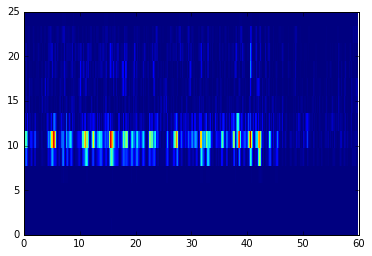

In [15]:
signal = raw._data[0,60000:120000]
signal.shape
f,t,Sxx = spectrogram(signal,fs=1000,window=('hamming'),nperseg=512,noverlap=511)
plt.pcolormesh(t,f,Sxx)
plt.ylim([0,25])

In [ ]:
sample=1
startPoint=30*sample;endPoint=30*(sample+1)
start,stop=raw.time_as_index([startPoint,endPoint])
segment,time=raw[:,start:stop]
for idx, channel_names in enumerate(channelList):
    yf = mne.time_frequency.stft(segment[idx,:],32,8)
    xf = np.linspace(0, 1000/2, len(yf))
    #plt.figure(idx)
    #plt.plot(yf)
#STFT_raw =mne.time_frequency.stft(raw,32,2)

In [22]:
def center_window_by_max_amplitude(raw,time,channelList,windowsWidth=2.0):
    startPoint=time-windowsWidth;endPoint=time+windowsWidth
    start,stop=raw.time_as_index([startPoint,endPoint])
    tempsegment,timespan=raw[:,start:stop]
    segment_dictionary={}
    for idx,name in enumerate(channelList):
        centerxval = timespan[np.argmax(abs(tempsegment[idx,:]))]
        startPoint=centerxval-windowsWidth/2;endPoint=centerxval+windowsWidth/2
        start,stop=raw.time_as_index([startPoint,endPoint])
        segment,_=raw[idx,start:stop]
    
        normalized_segment = (segment-np.mean(segment))/scipy.linalg.norm(segment)
        #yf = fft(segment[idx,:])[:50] 
        segment_dictionary[name]= normalized_segment
    return segment_dictionary

def from_time_markers_to_sample(channelList,raw,windowsWidth=2.0):
    data={}
    for names in channelList:
        data[names]=[]
    for moments in time:
        segments=center_window_by_max_amplitude(raw,moments, channelList,windowsWidth=windowsWidth)
        for names in channelList:
            data[names].append(segments[names])
    return data

def generate_label_sample(file,channelList,raw,windowsWidth=2.0,label='spindle'):
    data={};targetFind = re.compile(label, re.IGNORECASE);moments=0
    for names in channelList:
        data[names]=[]
    for row in file.iterrows():
        currentEvent=row[1][-1]
        if targetFind.search(currentEvent):
            moments=row[1][0]
        segments=center_window_by_max_amplitude(raw,moments, channelList,windowsWidth=windowsWidth)
        for names in channelList:
            data[names].append(segments[names])
    return data

def generate_nonevent_sample(raw,file,channelList,windowsWidth=2.0,exclude=['spindle','k-complex']):
    time_range=raw.last_samp/1000;initial_condition=file.iloc[0,-1];cnt=0
    while initial_condition != 'spindle':
        cnt +=1
        initial_condition = file.iloc[cnt,-1]
        
    
    initial_moment = file.iloc[cnt,-1]
    while initial_moment in exclude:
        time_stamp = random.randrange(0,time_range)
        startPoint=time_stamp-windowsWidth;endPoint=time_stamp+windowsWidth
        for row in file.iterrows():
            if startPoint<=row[1][0]<=endPoint:
                initial_moment=str(row[1][-1]).lower()
            else:
                initial_moment='non-event'
    

In [23]:
file=annotation_file(TXTfiles,sample_number=2)
spindles=generate_label_sample(file,channelList,raw)

ValueError: attempt to get argmax of an empty sequence

In [ ]:
train_data={}
for channel_names in channelList:
    train_data[channel_names]=[]
train_data['label']=[]
channel_index=mne.pick_types(raw.info,meg=False,eeg=True,eog=False,stim=False)

In [ ]:
sum(YLabel)/len(YLabel)

In [ ]:
for sample in range(len(YLabel)):
    startPoint=30*sample;endPoint=30*(sample+1)
    start,stop=raw.time_as_index([startPoint,endPoint])
    segment,time=raw[channel_index,start:stop]
    for idx, channel_names in enumerate(channelList):
        yf = 20*np.log10(np.abs(np.fft.rfft(segment[idx,:1000])))
        train_data[channel_names].append(yf)
    train_data['label'].append(YLabel[sample])

In [ ]:
sample=1
startPoint=30*sample;endPoint=30*(sample+1)
start,stop=raw.time_as_index([startPoint,endPoint])
segment,time=raw[channel_index,start:stop]
for idx, channel_names in enumerate(channelList):
    yf = 20*np.log10(np.abs(np.fft.rfft(segment[idx,:])))
    xf = np.linspace(0, 1000/2, len(yf))
    plt.figure(idx)
    plt.plot(yf)

In [ ]:
channelList=['F3','F4','C3','C4','O1','O2','ROC','LOC']
file_to_read,fileName = pick_sample_file(EDFfiles,n=1)
print(file_to_read)

raw=load_data(file_to_read,channelList,5,50)
windowLabel=annotation_to_labels(TXTfiles,sample_number=0,label='markon')
channelList=['F3','F4','C3','C4','O1','O2']
raw.pick_channels(channelList)
YLabel = label_binarize(['2','3'],classes=['w','1','2','3'])
validation_data={}
for channel_names in channelList:
    validation_data[channel_names]=[]
validation_data['label']=[]
channel_index=mne.pick_types(raw.info,meg=False,eeg=True,eog=False,stim=False)
for sample in range(len(YLabel)):
    startPoint=30*sample;endPoint=30*(sample+1)
    start,stop=raw.time_as_index([startPoint,endPoint])
    segment,time=raw[channel_index,start:stop]
    for idx, channel_names in enumerate(channelList):
        yf = 20*np.log10(np.abs(np.fft.rfft(segment[idx,:1000])))
        validation_data[channel_names].append(yf)
validation_data['label'].append(YLabel[sample])

In [ ]:
raw.plot()

In [ ]:
YLabel = label_binarize(windowLabel,classes=['2','3'])
YLabel.sum(axis=0)/len(YLabel)

In [ ]:
#clf = LogisticRegression(penalty='l1',C=0.5,tol=10e-10,fit_intercept=True,solver='liblinear',max_iter=1000,multi_class='ovr',
#                        n_jobs=-1)
clf = OneVsRestClassifier(SVC(kernel='linear',probability=True,random_state=101))
weight_30s = {};y_pred={};cnt=1
for channel_name in channelList:
    
    clf.fit(train_data[channel_name],train_data['label'])
    weight_30s[channel_name]=clf
    y_pred[channel_name]=clf.decision_function(validation_data[channel_name])
    precision={};recall={};average_precision={}
    for i in range(len(train_data['label'])+len(validation_data['label'])):
        precision[i],recall[i],_=precision_recall_curve(validation_data['label'],)
    print(channel_name,classification_report(validation_data['label'],y_pred[channel_name]))
    print(channel_name,accuracy_score(validation_data['label'],y_pred[channel_name],normalize=False)/len(validation_data['label']))
    print(channel_name,np.array(validation_data['label']).sum())

In [ ]:
sample_number = 0
channelList=['F3','F4','C3','C4','O1','O2','ROC','LOC']
file_to_read,fileName = pick_sample_file(EDFfiles,n=sample_number)
print(file_to_read)
raw=load_data(file_to_read,channelList,5,50)
channelList=['F3','F4','C3','C4','O1','O2']

raw.pick_channels(channelList)

file = annotation_file(TXTfiles,sample_number=sample_number)

spindleFind = re.compile("spindle", re.IGNORECASE)
complexFind = re.compile("complex",re.IGNORECASE)
markPairs=[];dataLabels=[];eventCount=0;time=[]
for row in file.iterrows():
    currentEvent = row[1][-1]
    if spindleFind.search(currentEvent):
        time.append(row[1][0])
    

spindles={}
for names in channelList:
    spindles[names]=[]
for moments in time:
    segments = center_window_by_max_amplitude(raw,moments,channelList,windowsWidth=2.0)
    for names in channelList:
        spindles[names].append(segments[names])
        


In [ ]:
for ii,names in enumerate(channelList):
    plt.subplot(3,2,ii+1)
    plt.title(names)
    for idx in range(len(data[names])):
        
        plt.plot(data[names][idx])

In [ ]:
sample=-1
for ii in range(6):
    startPoint=time[sample]-2;endPoint=time[sample]+2
    start,stop=raw.time_as_index([startPoint,endPoint])
    tempsegment,timespan=raw[:,start:stop]
    centerxval = timespan[np.argmax(abs(tempsegment[ii,:]))]
    startPoint=centerxval-1;endPoint=centerxval+1
    start,stop=raw.time_as_index([startPoint,endPoint])
    segment,_=raw[:,start:stop]
    plt.subplot(221)
    normalized_segment=(segment[ii,:]-np.mean(segment[ii,:]))/scipy.linalg.norm(segment[ii,:])
    plt.plot(range(len(normalized_segment)),normalized_segment)
    plt.subplot(222)
    yf = fft(normalized_segment)[:50]
    plt.plot(np.fft.fftfreq(len(yf),np.abs(yf)))
    
    startPoint=time[sample+1]-2;endPoint=time[sample+1]+2
    start,stop=raw.time_as_index([startPoint,endPoint])
    tempsegment,timespan=raw[:,start:stop]
    centerxval = timespan[np.argmax(abs(tempsegment[ii,:]))]
    startPoint=centerxval-0.75;endPoint=centerxval+0.75
    start,stop=raw.time_as_index([startPoint,endPoint])
    segment,_=raw[:,start:stop]
    plt.subplot(223)
    normalized_segment=(segment[ii,:]-np.mean(segment[ii,:]))/scipy.linalg.norm(segment[ii,:])
    plt.plot(range(len(normalized_segment)),normalized_segment)
    plt.subplot(224)
    yf = fft(normalized_segment)[:50]
    plt.plot(np.fft.fftfreq(len(yf),np.abs(yf)))

In [ ]:
        if (spindleFind.search(curEvent) or complexFind.search(curEvent)):
            time = row[1][0]
            startTime = int(time - (duration*proprotion))
            endTime = int(time + (duration*(1-proprotion)))
            markPairs.append([startTime, endTime])
            if spindleFind.search(curEvent):
                dataLabels.append(0)
            if complexFind.search(curEvent):
                dataLabels.append(1)
            eventCount += 1

In [ ]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i];#print(this)
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

if __name__=="__main__":
    from matplotlib.pyplot import plot, scatter, show
    fs = 1000 # sample rate 
    f = 20 # the frequency of the signal
    x = np.arange(fs)
    y = [ np.sin(2*np.pi*f * (i/fs)) for i in np.arange(fs)]+[ np.tan(2*np.pi*(f+5 )* (i/fs)) for i in np.arange(fs)]
    series = y
    maxtab, mintab = peakdet(series,1);print(maxtab.shape,mintab.shape)
    plot(series)
    scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
    scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
    show()

In [5]:
channelList=['F3','F4','C3','C4','O1','O2','ROC','LOC']
file_to_read,fileName = pick_sample_file(EDFfiles,n=2)
print(file_to_read)
#http://www.eurasip.org/Proceedings/Eusipco/Eusipco2005/defevent/papers/cr1847.pdf
raw=load_data(file_to_read,channelList,8,22)

suj10_d1final.edf
Extracting edf Parameters from suj10_d1final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 3601999  =      0.000 ...  3601.999 secs...
[done]
Ready.
Band-pass filtering from 8 - 22 Hz
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 2 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    6, 7, 7, 6, 3
    Removing duplicate indices...
Ready.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 8 PCA components


In [ ]:
initial_window=2
distance_to_end = raw.last_samp/1000 - initial_window
while distance_to_end >0:
    window = initial_window
    initial_window += 0.5
    startPoint=window-2;endPoint=window
    start,stop = raw.time_as_index([startPoint,endPoint])
    segment,time = raw[0,start:stop]
    mne.filter.band_pass_filter(segment,1000,)

In [7]:
initial_window=[0,2]
initial_window +=2
initial_window

TypeError: 'int' object is not iterable